In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 27 11:19:07 2020

@author: Max J. de Bock
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import make_interp_spline, BSpline
import numpy.polynomial.polynomial as poly
import statistics as stat
from scipy.signal import find_peaks
from scipy.stats import norm


In [9]:
df = pd.DataFrame({'Series': [np.nan], 'Epsilon': [np.nan], 'Sd': [np.nan]}).dropna()
def LoadData():
    SP = pd.read_csv('^GSPC.csv')
    print(SP)
    return SP

# White noise 

In [10]:
def WhiteNoise(df,mean,sd):
    n = 100
    for i in range(n):
        Xt = np.random.normal(mean,sd)
        df = df.append({'Series': Xt}, ignore_index=True)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

# Qth-Order Moving Average:

In [11]:
def QthMovAve(df,mean,sd,order):
    weights = np.linspace(1,order,order)
    weights = weights/np.sum(weights)
    n = 1000
    for i in range(n):
        epsilon = np.random.normal(0,sd)
        Xt = mean
        if i != 0:
            for j in range(np.minimum(i,order-1)):    
                 Xt += weights[order-j-1]*df['Epsilon'].iloc[i-j-1]
        df = df.append({'Series': Xt, 'Epsilon': epsilon}, ignore_index=True)
    print(df)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

In [12]:
def SquaredErrorforCycleLength(A,length):
    A = np.array(A)
    var_list = np.zeros(length)
    n = len(A)
    for i in range(length):
        k = 0
        point_list = []
        while k*length <= n-1:
            point_list.append(A[k*length])
            k += 1
        var_list[i] = stat.variance(point_list)
    return stat.mean(var_list)

Thing that tries to find period of periodic function:

In [13]:
def CycleLength(A):
    A = np.array(A)
    SquaredErrors = np.zeros(int(len(A)*2/3))
    for length in range(1,int(len(A)*2/3)):
        SquaredErrors[length] = SquaredErrorforCycleLength(A, length)
    return SquaredErrors

# Qth-Order Auto-regressive:

In [14]:
def QthAR(df,sd,order):
    weights = np.linspace(1,order,order)
    weights = weights/np.sum(weights)
    n = 100
    for i in range(n):
        epsilon = np.random.normal(0,sd)
        Xt = epsilon
        if i != 0:
            for j in range(np.minimum(i,order)):
                Xt += weights[order-j-1]*df['Series'].iloc[i-j-1]
        df = df.append({'Series': Xt}, ignore_index=True)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

# Qth-order Auto-regressive conditional heteroskedasticity (ARCH):

In [15]:
def QArch(df,a,order):
    #Choosing the weights of the model (assuming weakly-stationary covariance)
    weights = np.linspace(1,order,order)
    weights = (200)**(weights/order)
    weights = weights/np.sum(weights)
    n = 1000
    for i in range(n):
        #This is that first term constant
        sd = a
        for j in range(np.minimum(i,order+1)):
            #Summing the products of the weights and squares of previous datapoints
            sd += weights[order-j-1]*df['Series'].iloc[i-j-1]*df['Series'].iloc[i-j-1]
        #Generating next datapoint
        Xt = np.random.normal(0,sd)
        df = df.append({'Series': Xt, 'Sd': sd}, ignore_index=True)
    #Just formatting
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('ARCH(%d)' % order)
    lin = np.linspace(1,n,n)
    ax1.bar(lin,df['Series'])
    ax2.bar(lin,df['Sd'])
    #Getting an approximating poly through it uses Gaussian quadrature,
    #so it is going to be exact up to n/2. This is why I picked n/smoothness.
    #This is really just a randomly chosen number, but line looks good for smoothness = 10 .
    smoothness = 10
    degree = int(np.ceil(n/smoothness))
    xnew = np.linspace(1,n, n*smoothness) 
    coefs = poly.polyfit(lin, df['Sd'], degree)
    ffit = poly.polyval(xnew, coefs)
    plt.plot(xnew, ffit, 'r')
    # #More formatting
    low = min(df['Sd'])
    high = max(df['Sd'])
    plt.ylim([low,high])
    print(low)
    ax3 = ax2.twinx()
    cycle_length = CycleLength(ffit[1::smoothness])
    l = len(cycle_length)
    ax3.plot(np.linspace(1,l,l),cycle_length, 'g')
    fig.tight_layout()
    plt.show()
    return find_peaks(cycle_length, \
                      #threshold = (max(cycle_length)-min(cycle_length))/40),\
                      width = 10)

# Plotting daily-changes in histogram (and fitting Gaussian distribution):

In [16]:
def ChangePlot(A):
    A['Change'] = A['Close']-A['Open']
    
    plt.hist(sp['Change'], bins=100, density = True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, std = norm.fit(A['Change'])
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


0.1


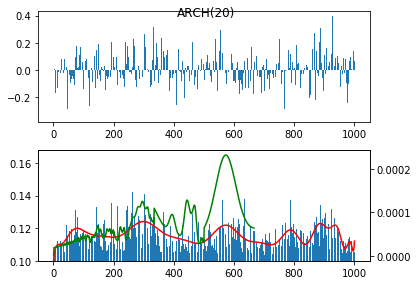

(array([147, 187, 222, 295, 334, 393, 443, 572], dtype=int64),
 {'prominences': array([3.50581002e-05, 2.11240238e-05, 2.91986499e-05, 7.81422541e-05,
         3.50364279e-05, 2.79592119e-05, 9.99325234e-05, 1.68176172e-04]),
  'left_bases': array([  0, 164, 212,   0, 333, 372,   0,   0], dtype=int64),
  'right_bases': array([212, 212, 240, 419, 419, 419, 484, 665], dtype=int64),
  'widths': array([17.4434851 , 16.3882323 , 19.38705365, 57.47666838, 12.94533269,
         17.6165592 , 42.61710368, 74.59915544]),
  'width_heights': array([5.22561028e-05, 5.17185603e-05, 5.21054987e-05, 8.63584058e-05,
         9.20167839e-05, 8.12164731e-05, 7.82704715e-05, 1.47908783e-04]),
  'left_ips': array([141.11030287, 174.02828468, 217.52790465, 261.70982667,
         333.5       , 383.58756904, 431.78524442, 534.86443084]),
  'right_ips': array([158.55378797, 190.41651698, 236.9149583 , 319.18649505,
         346.44533269, 401.20412824, 474.4023481 , 609.46358628])})

In [17]:
QArch(df,0.1,20)